In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torch

# Dataset

In [5]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

Chosen tickers: ['SBER', 'SBERP', 'LKOH', 'VTBR', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


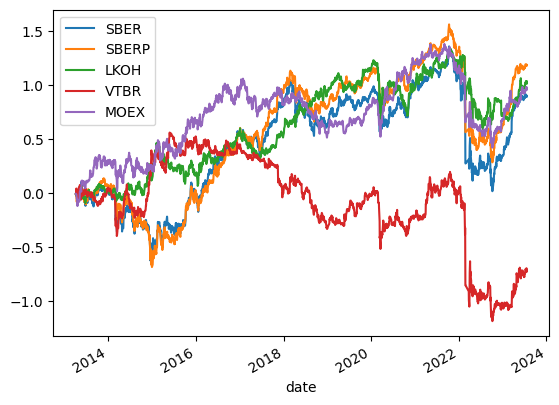

In [6]:
df_returns_real.cumsum().plot()
plt.show()

# GAN


In [7]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [8]:
from gan import Discriminator, Generator

assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


## Train

100 epochs train time: 679.8s. Estimated train time: 79.3m
Fake std: [0.20792307 0.19590692 0.1925086  0.18972851 0.1505387 ].
Real std: [0.02320357 0.02170969 0.01934618 0.02256658 0.01871406]
Fake correlation: -0.47019887553419604. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


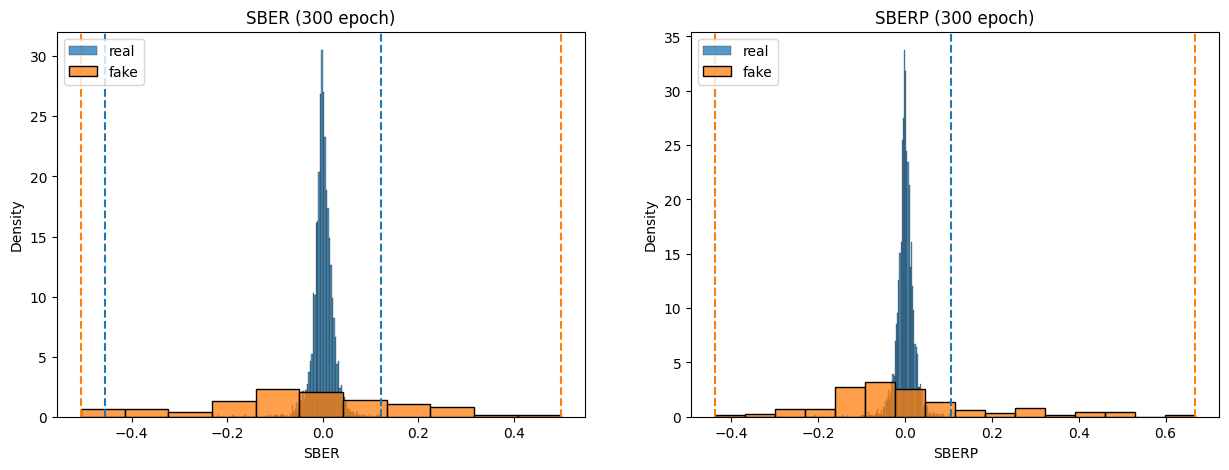

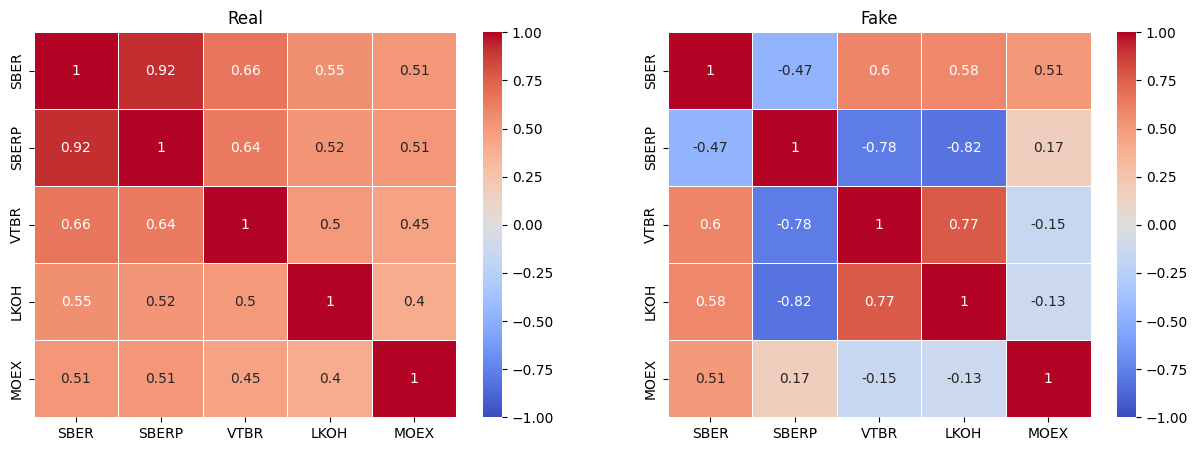

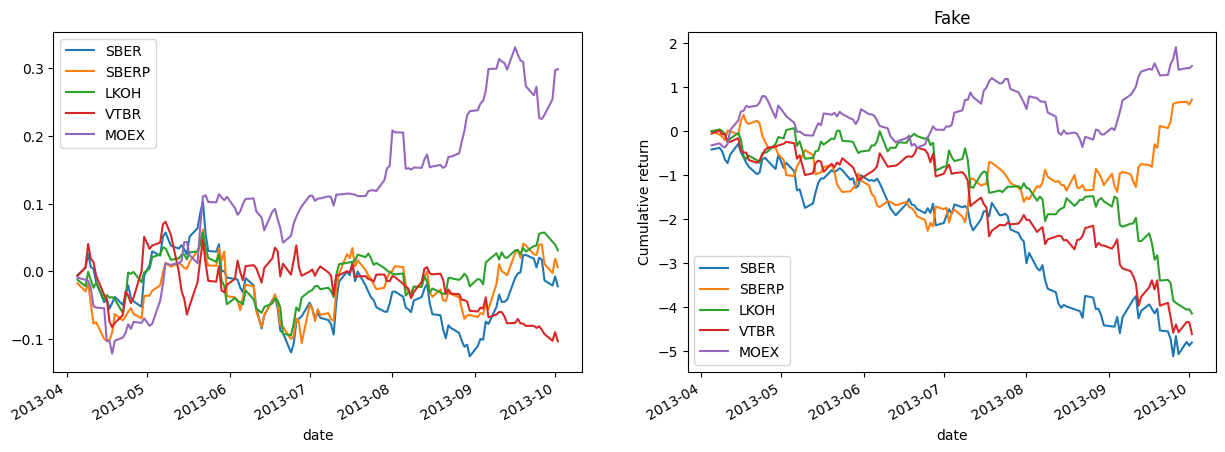

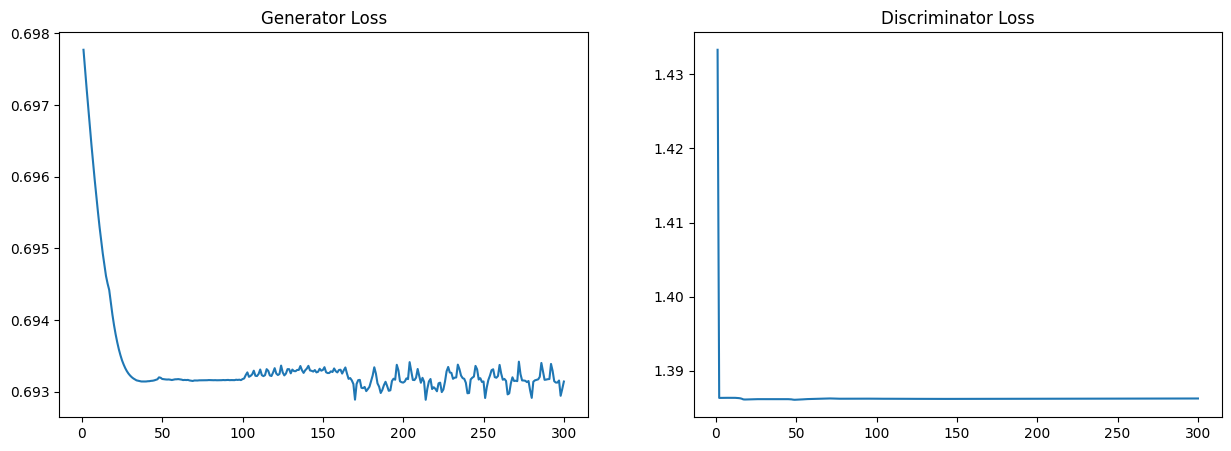

KeyboardInterrupt: 

In [7]:
from gan_train_loop import train_gan

N_EPOCHS = 1000
LOG_FREQUENCY = 100
SAVE_FREQUENCY = 200

torch.manual_seed(1) # добавил, чтобы генерации были одинаковыми
# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses, generator_losses = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='TCN')

In [ ]:
plt.plot(range(10, len(discriminator_losses)), discriminator_losses[10:])
plt.show()
plt.plot(range(10, len(generator_losses)), generator_losses[10:])
plt.show()

# Generation

## Generate random history

## Plot cumulative real and fake returns

In [9]:
# Грузим свой
from generation import generate_fake_returns
from gan_train_loop import load_gan

generator_my = Generator().to(DEVICE)

load_gan('TCN', generator_my, epoch=1000)
my_df_returns_fake = generate_fake_returns(generator_my, df_returns_real, seed=0)

Load 1000 epoch checkpoint


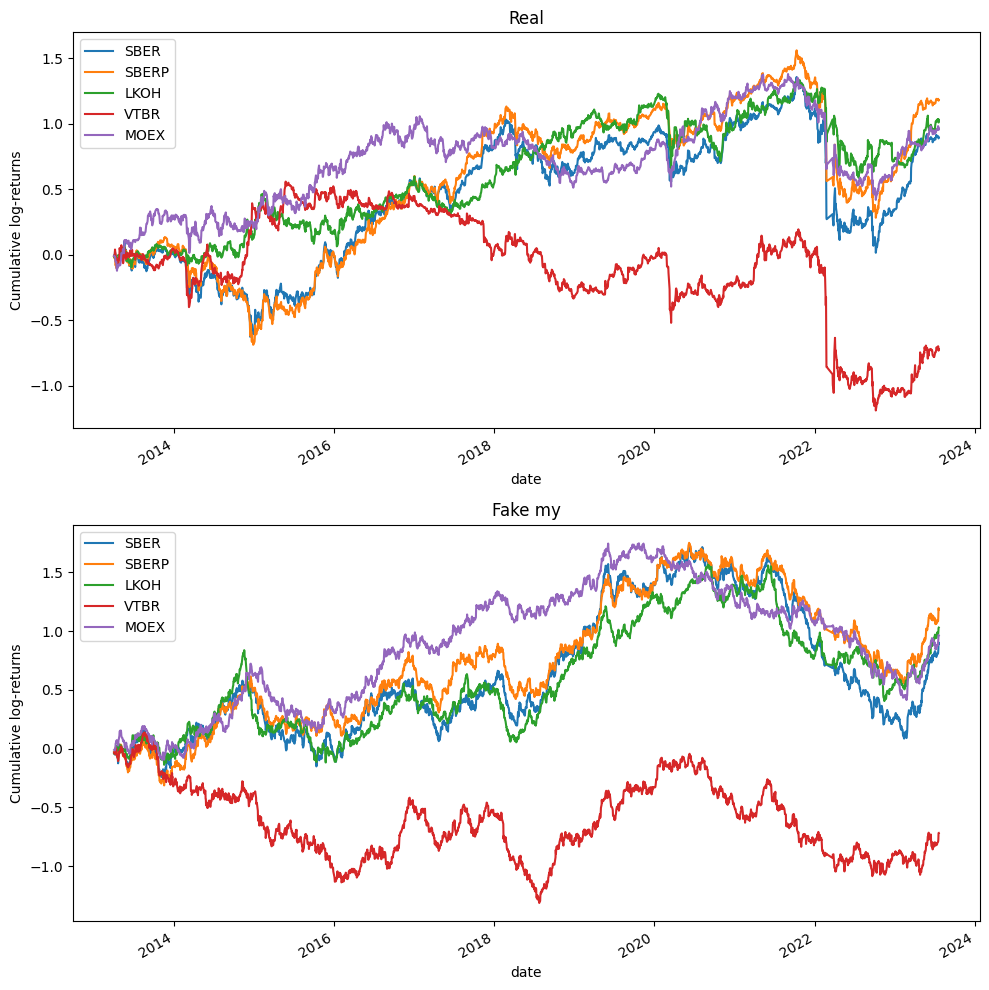

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
my_df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake my')
plt.ylabel('Cumulative log-returns')

plt.tight_layout()

plt.show()

## Plot correlation matrix for real and fake returns

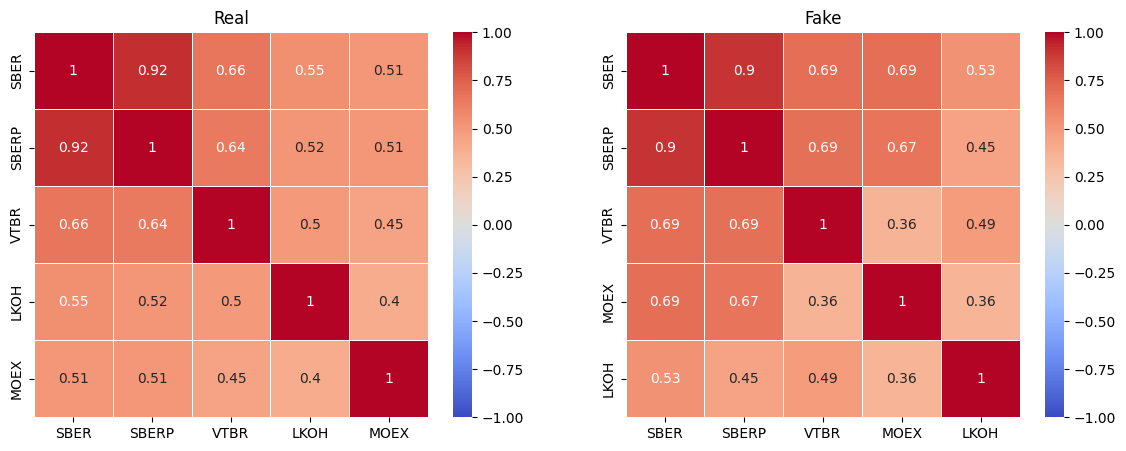

In [13]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(my_df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Plot returns distribution

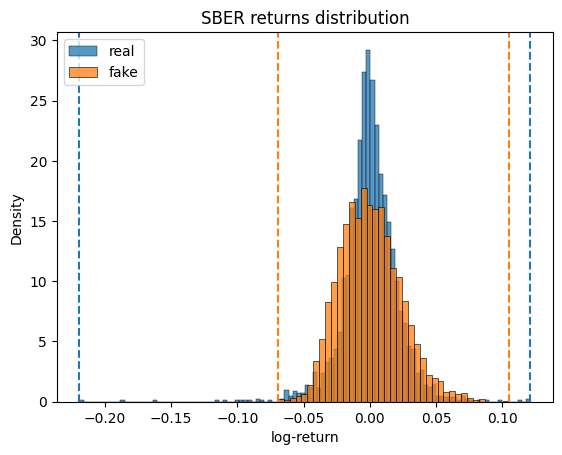

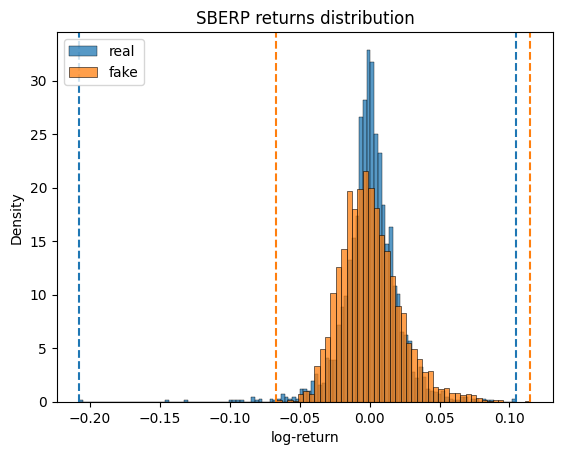

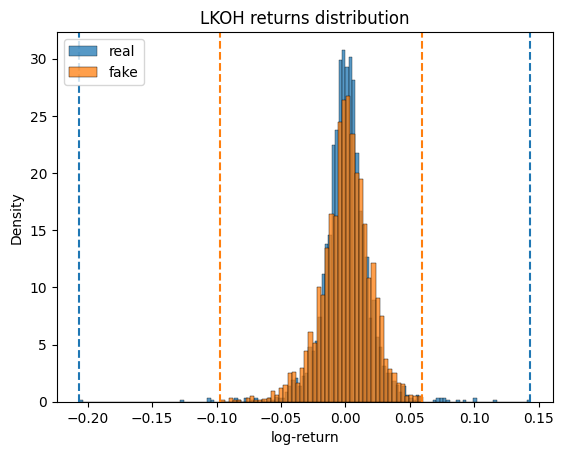

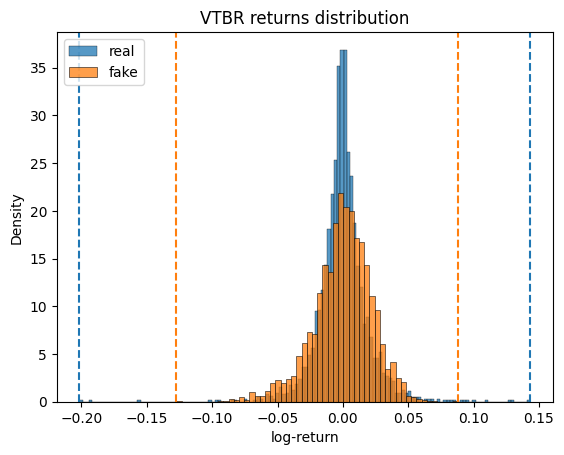

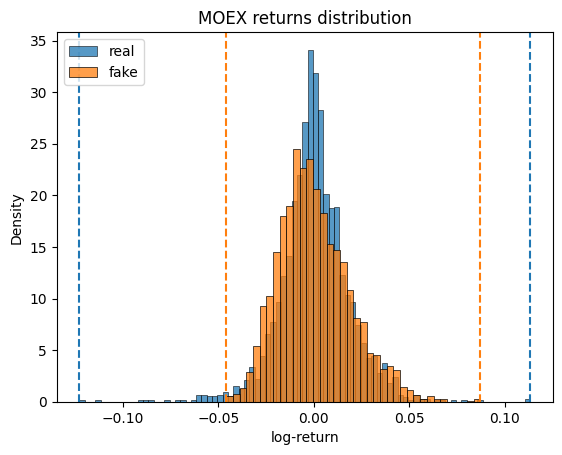

In [15]:
tmp_df_returns_real = df_returns_real[df_returns_real.sum(axis=1) != df_returns_real.sum(axis=1).min()]

for col in df_returns_real.columns:
    # Plot returns distributions
    sns.histplot(tmp_df_returns_real[col], stat='density', label='real')
    sns.histplot(my_df_returns_fake[col], stat='density', label='fake')

    # Plot real returns bounds
    plt.axvline(tmp_df_returns_real[col].min(), linestyle='dashed', color='C0')
    plt.axvline(tmp_df_returns_real[col].max(), linestyle='dashed', color='C0')

    # Plot fake returns bounds
    plt.axvline(my_df_returns_fake[col].min(), linestyle='dashed', color='C1')
    plt.axvline(my_df_returns_fake[col].max(), linestyle='dashed', color='C1')

    plt.xlabel('log-return')
    plt.legend(loc='upper left')
    plt.title(f'{col} returns distribution')
    plt.show()